# Top Hit Song Prediction
This is to test the top song prediction.

## Dependecy
Here are the depedency that I'm currently using to helping run the prediction and handling the data.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

## Cleaning Data
Before we begin with anything, the data should be cleaned first.

### Remove Missing Data
For High popularity

In [3]:
# Add csv data to songs
high_song_popularity = pd.read_csv("high_popularity_spotify_data.csv")

# Drop useless column
high_song_popularity.drop(columns=['track_href', 'uri', 'track_album_name', 'playlist_name', 'analysis_url',
                                    'track_id', 'track_album_id', 'type', 'playlist_id'], inplace=True)

# Show the total number of null in each column.
print(high_song_popularity.isnull().sum())

energy                      0
tempo                       0
danceability                0
playlist_genre              0
loudness                    0
liveness                    0
valence                     0
track_artist                0
time_signature              0
speechiness                 0
track_popularity            0
track_name                  0
track_album_release_date    0
instrumentalness            0
mode                        0
key                         0
duration_ms                 0
acousticness                0
id                          0
playlist_subgenre           0
dtype: int64


For low popularity

In [4]:
# Add csv data to songs
low_song_popularity = pd.read_csv("low_popularity_spotify_data.csv")

# Drop useless column
low_song_popularity.drop(columns=['track_href', 'uri', 'track_album_name', 'playlist_name', 'analysis_url',
                                    'track_id', 'track_album_id', 'type', 'playlist_id'], inplace=True)

# Drop row containing null for time_signature
low_song_popularity = low_song_popularity.dropna(subset='time_signature')

# Show the total number of null in each column.
print(low_song_popularity.isnull().sum())

time_signature              0
track_popularity            0
speechiness                 0
danceability                0
track_artist                0
duration_ms                 0
energy                      0
playlist_genre              0
playlist_subgenre           0
track_name                  0
mode                        0
track_album_release_date    0
id                          0
instrumentalness            0
valence                     0
key                         0
tempo                       0
loudness                    0
acousticness                0
liveness                    0
dtype: int64


## Audio Features
Here is the description of each audio features in the dataset.

-Energy         =   A measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. The higher it is the engergetic it is.

-Tempo           =   The speed of a track, measured in beats per minute (BPM).

-Danceability    =   A score describing how suitable a track is for dancing based on tempo, rhythm stability, beat strength and overall regularity.

-Loudness        =   The overall loudness of a track in decibels (dB). Higher values indicate louder tracks overall.

-Liveness        =   The likelihood of a track being performed live. Higher values suggest more audience presence.

-Valence         =   The overall musical positiveness(emotion) of a track. High valence sounds happy; low valence sounds sad or angry.

-Speechiness     =   Measures the presence of spoken words.

-Instrumentalness =   The likelihood a track contains no vocals. Values closer to 1.0 suggest solely instrumental tracks.

-Acousticness    =   A confidence measure of whether a track is acoustic(1) or not(0).

-Mode            =   Indicates the modality of the track.

-Key             =   The musical key, represented as an integer from 0 to 11, mapping to standard Pitch class notation.

-Duration_ms     =   The length of the track in milliseconds.

In [39]:
# Avarage
high_popularity_avg = high_song_popularity['track_popularity'].mean()
low_popularity_avg = low_song_popularity['track_popularity'].mean()

# Max
max_popular_high_popularity = high_song_popularity['track_popularity'].max()
max_popular_low_popularity = low_song_popularity['track_popularity'].max()

# Min
min_popular_high_popularity = high_song_popularity['track_popularity'].min()
min_popular_low_popularity = low_song_popularity['track_popularity'].min()

# Total of number
count_max_popular_high_popularity = (high_song_popularity['track_popularity'] == 100).sum()
count_max_popular_low_popularity = (low_song_popularity['track_popularity'] == 68).sum()

count_min_popular_high_popularity = (high_song_popularity['track_popularity'] == 68).sum()
count_min_popular_low_popularity = (low_song_popularity['track_popularity'] == 11).sum()

# Show
print('popular track for high average popularity:', high_popularity_avg)
print('max popular track for high average popularity:', max_popular_high_popularity)
print('min popular track for high average popularity:', min_popular_high_popularity)
print('features for popularity')

print('popular track for low average popularity:', low_popularity_avg)
print('max popular track for low average popularity:', max_popular_low_popularity)
print('min popular track for low average popularity:', min_popular_low_popularity)
print('features for non popularity')

print('the number of high popularity for 68: ', count_min_popular_high_popularity, ' and for low popularity for 68:', count_max_popular_low_popularity)

popular track for high average popularity: 75.80604982206405
max popular track for high average popularity: 100
min popular track for high average popularity: 68
features for popularity
popular track for low average popularity: 43.47709923664122
max popular track for low average popularity: 68
min popular track for low average popularity: 11
features for non popularity
the number of high popularity for 68:  124  and for low popularity for 68: 45


## Visualization and analyze trends


### Compare The Average Popular and Non-popular Audio Features by Song Genres
This bar chart compares the average values of audio features between popular and non-popular songs across different genres. It helps artists gain insights and identify patterns in how features like energy, danceability, and tempo behave in popular versus non-popular songs within each genre.

By analyzing these differences, artists can better understand what characteristics are commonly found in successful songs in their chosen genre. This can guide them in targeting ideal feature values when producing new song.

All audio feature values in the chart are normalized to a scale between 0 and 1. This is important because features like tempo and loudness normally exist on different scales, and normalization ensures a fair visual comparison across all features.

In [38]:
# Features to include
features = ['energy', 'danceability', 'valence', 'acousticness', 'instrumentalness', 'tempo', 'loudness']

# Combine and get min/max for normalization
combined_df = pd.concat([high_song_popularity, low_song_popularity])
feature_min = combined_df[features].min()
feature_max = combined_df[features].max()

# Normalize and retain original values for tooltip
high_norm = high_song_popularity.copy()
low_norm = low_song_popularity.copy()

for feature in features:
    high_norm[feature + '_orig'] = high_song_popularity[feature]
    low_norm[feature + '_orig'] = low_song_popularity[feature]
    high_norm[feature] = (high_song_popularity[feature] - feature_min[feature]) / (feature_max[feature] - feature_min[feature])
    low_norm[feature] = (low_song_popularity[feature] - feature_min[feature]) / (feature_max[feature] - feature_min[feature])

# Unique genres with valid data
genres = sorted(set(high_norm['playlist_genre'].unique().tolist() + low_norm['playlist_genre'].unique().tolist()))
data_by_genre = {}

for genre in genres:
    pop_filtered = high_norm[high_norm["playlist_genre"] == genre]
    non_pop_filtered = low_norm[low_norm["playlist_genre"] == genre]
    if pop_filtered.empty or non_pop_filtered.empty:
        continue

    pop_avg = pop_filtered[features].mean()
    non_pop_avg = non_pop_filtered[features].mean()
    pop_raw = pop_filtered[[f + "_orig" for f in features]].mean()
    non_pop_raw = non_pop_filtered[[f + "_orig" for f in features]].mean()

    data_by_genre[genre] = {
        "pop_norm": pop_avg,
        "non_pop_norm": non_pop_avg,
        "pop_raw": pop_raw,
        "non_pop_raw": non_pop_raw
    }

# Keep only genres with data
genres = list(data_by_genre.keys())
initial_genre = genres[0]

# Create figure with initial genre
fig = go.Figure()

# Add normalized bars with raw values in customdata
fig.add_trace(go.Bar(
    name='Popular songs',
    x=features,
    y=data_by_genre[initial_genre]['pop_norm'],
    marker_color='green',
    customdata=data_by_genre[initial_genre]['pop_raw'].values.reshape(-1, 1),
    hovertemplate='%{x}<br>Normalized: %{y:.2f}<br>Raw: %{customdata[0]:.2f}<extra></extra>'
))

fig.add_trace(go.Bar(
    name='Non-popular songs',
    x=features,
    y=data_by_genre[initial_genre]['non_pop_norm'],
    marker_color='blue',
    customdata=data_by_genre[initial_genre]['non_pop_raw'].values.reshape(-1, 1),
    hovertemplate='%{x}<br>Normalized: %{y:.2f}<br>Raw: %{customdata[0]:.2f}<extra></extra>'
))

# Dropdown buttons
dropdown_buttons = []
for genre in genres:
    dropdown_buttons.append({
        'label': genre.title(),
        'method': 'update',
        'args': [
            {
                'y': [
                    data_by_genre[genre]['pop_norm'],
                    data_by_genre[genre]['non_pop_norm']
                ],
                'customdata': [
                    data_by_genre[genre]['pop_raw'].values.reshape(-1, 1),
                    data_by_genre[genre]['non_pop_raw'].values.reshape(-1, 1)
                ]
            },
            {
                'title': f'Feature Comparison (Normalized with Raw Tooltips): Popular vs. Non-Popular {genre.title()} Songs'
            }
        ]
    })

# Layout
fig.update_layout(
    updatemenus=[
        {
            'buttons': dropdown_buttons,
            'direction': 'down',
            'showactive': True,
            'x': 1.0,
            'y': 1.2,
            'xanchor': 'left',
            'yanchor': 'top'
        }
    ],
    title=f'Feature Comparison (Normalized with Raw Tooltips): Popular vs. Non-Popular {initial_genre.title()} Songs',
    xaxis_title='Features',
    yaxis_title='Normalized Value (0 - 1)',
    barmode='group',
    template='plotly_dark',
    height=500
)

fig.show()

### Heatmap Correlation for Popular Songs Between Audio Features
This heatmap helps artists understand the relationships between different audio features. A strong positive correlation (closer to +1) means two features increase together, for example, higher energy often means higher loudness. A strong negative correlation (closer to –1) means as one feature increases, the other decreases, such as more acoustic songs often being less energetic. A correlation close to 0 means there's no meaningful relationship between the two features.

This heatmap is not about predicting popularity directly. Instead, it shows how features relate to one another across popular songs. Artists can use it to see which features influence each other, for example, if you want to raise your song’s danceability, the heatmap can show which other traits (like energy or valence) tend to rise with it.

In [5]:
# Define features
features = ['energy', 'danceability', 'valence', 'acousticness', 'instrumentalness', 'tempo', 'loudness']

# Normalize 'tempo' and 'loudness' for both datasets
scaler = MinMaxScaler()
high_song_popularity[['tempo', 'loudness']] = scaler.fit_transform(high_song_popularity[['tempo', 'loudness']])

# Correlation matrices
corr_popular = high_song_popularity[features].corr()

# Popular songs heatmap
fig_popular = px.imshow(
    corr_popular,
    text_auto='.2f',
    color_continuous_scale='Viridis',
    labels=dict(x="Audio Feature", y="Audio Feature", color="Correlation")
)

fig_popular.update_layout(
    title="Correlation Between Audio Features (Popular Songs)",
    width=700,
    height=700,
    template="plotly_dark"
)

# Show both
fig_popular.show()

In [ ]:
# Define features
features = ['energy', 'danceability', 'valence', 'acousticness', 'instrumentalness', 'tempo', 'loudness']

# Normalize 'tempo' and 'loudness' for both datasets
scaler = MinMaxScaler()
high_song_popularity[['tempo', 'loudness']] = scaler.fit_transform(high_song_popularity[['tempo', 'loudness']])
low_song_popularity[['tempo', 'loudness']] = scaler.fit_transform(low_song_popularity[['tempo', 'loudness']])

# Correlation matrices
corr_popular = high_song_popularity[features].corr()
corr_non_popular = low_song_popularity[features].corr()

# Popular songs heatmap
fig_popular = px.imshow(
    corr_popular,
    text_auto='.2f',
    color_continuous_scale='Viridis',
    labels=dict(x="Audio Feature", y="Audio Feature", color="Correlation")
)

fig_popular.update_layout(
    title="Correlation Between Audio Features (Popular Songs)",
    width=700,
    height=700,
    template="plotly_dark"
)

# Non-popular songs heatmap
fig_non_popular = px.imshow(
    corr_non_popular,
    text_auto='.2f',
    color_continuous_scale='Viridis',
    labels=dict(x="Audio Feature", y="Audio Feature", color="Correlation")
)

fig_non_popular.update_layout(
    title="Correlation Between Audio Features (Non-Popular Songs)",
    width=700,
    height=700,
    template="plotly_dark"
)

# Show both
fig_popular.show()
fig_non_popular.show()

In [12]:
# Define features
features = ['energy', 'danceability', 'valence', 'acousticness', 'instrumentalness', 'tempo', 'loudness']

# Normalize 'tempo' and 'loudness'
scaler = MinMaxScaler()
high_song_popularity[['tempo', 'loudness']] = scaler.fit_transform(high_song_popularity[['tempo', 'loudness']])
low_song_popularity[['tempo', 'loudness']] = scaler.fit_transform(low_song_popularity[['tempo', 'loudness']])

# Compute correlation matrices
corr_popular = high_song_popularity[features].corr()
corr_non_popular = low_song_popularity[features].corr()

# Compute difference matrix
corr_diff = corr_popular - corr_non_popular

# Plot difference heatmap
fig_diff = px.imshow(
    corr_diff,
    text_auto='.2f',
    color_continuous_scale='RdBu',
    zmin=-1, zmax=1,
    labels=dict(x="Audio Feature", y="Audio Feature", color="Correlation Difference")
)

fig_diff.update_layout(
    title="🔍 Difference in Audio Feature Correlations (Popular - Non-Popular)",
    width=700,
    height=700,
    template="plotly_dark"
)

fig_diff.show()

### Exploring Genre Popularity in Music
This donut chart helps artists gain insight into the average popularity of songs in each genre. It also provides a way to discover hidden or less saturated genres. The donut chart splits the pie into segments based on each genre. The size of each segment represents the total number of songs in that specific genre, while the color reflects the average popularity. Lighter shades indicate lower popularity, and darker blue tones represent higher popularity.


In [6]:
# Combined popularity
combined_popularity = pd.concat([high_song_popularity, low_song_popularity], ignore_index=True)

# Group by genre
genre_df = combined_popularity.groupby('playlist_genre').agg(
    song_count=('track_name', 'count'),
    avg_popularity=('track_popularity', 'mean')
).reset_index()

# Normalize popularity to map to color
max_pop = genre_df['avg_popularity'].max()
min_pop = genre_df['avg_popularity'].min()
norm_pop = (genre_df['avg_popularity'] - min_pop) / (max_pop - min_pop)

# Create colorscale
colorscale = 'YlGnBu'
colors = [px.colors.sample_colorscale(colorscale, p)[0] for p in norm_pop]

# Setup pie chart with custom coloring
genre_pie = go.Figure(data=[go.Pie(
    labels=genre_df['playlist_genre'],
    values=genre_df['song_count'],
    hole=0.4,
    name='',
    marker=dict(colors=colors),
    hovertemplate='<b>%{label}</b><br>Song Count: %{value}<br>Avg Popularity: %{customdata:.1f}',
    customdata=genre_df[['avg_popularity']].values,
    textinfo='label+value'
)])

# Manually add color scale as an annotation (since Pie doesn't support built-in colorbars)
colorbar_trace = go.Scatter(
    x=[None],
    y=[None],
    mode='markers',
    marker=dict(
        colorscale=colorscale,
        cmin=min_pop,
        cmax=max_pop,
        colorbar=dict(title='Avg Popularity'),
        showscale=True,
        size=1,
        color=[min_pop]  # Dummy value
    ),
    hoverinfo='none'
)

genre_pie.add_trace(colorbar_trace)

# Update layout size
genre_pie.update_layout(
    width=1200,
    height=1000,
    title='Genre Distribution by Song Count (Colored by Avg Popularity)',
    #coloraxis_colorbar=dict(title="Avg Popularity"),
    showlegend=False
)

genre_pie.show()

#### Result
From the donut chart, the genre with the highest average popularity is R&B, with an average popularity of 76.2 and only 50 songs, making it a less saturated genre. Artists could potentially focus on creating songs in this genre to increase their chances of a hit. The genre with the most songs is Electronic, with 589 songs, but it has a lower average popularity of 52.9.

### Sub Genre

In [7]:
# Only aggregate by genre + sub-genre
subgenre_df = combined_popularity.groupby(['playlist_genre', 'playlist_subgenre']).agg(
    song_count=('track_name', 'count'),
    avg_popularity=('track_popularity', 'mean')
).reset_index()

# Plot: size = song count, color = avg popularity
import plotly.express as px

fig = px.sunburst(subgenre_df,
                  path=['playlist_genre', 'playlist_subgenre'],
                  values='song_count',            # size by actual count
                  color='avg_popularity',         # color by average popularity
                  color_continuous_scale='YlGnBu',
                  title='Genre & Sub-genre by Song Count and Popularity')

fig.update_layout(width=1000, height=1000)
fig.show()

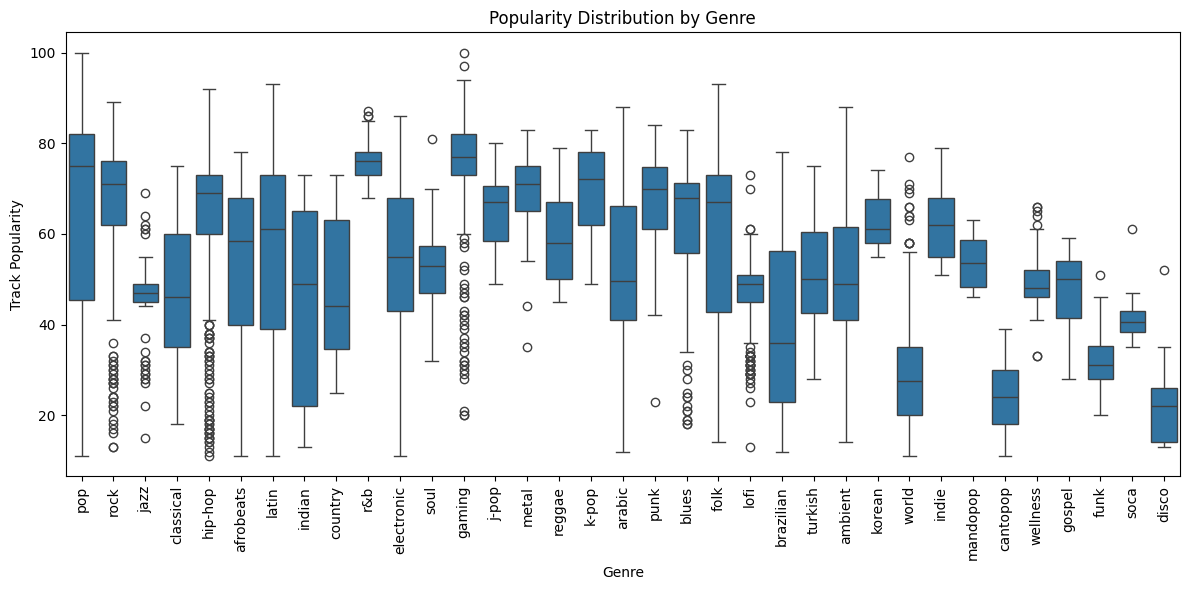

In [8]:
# Combined popularity
combined_popularity = pd.concat([high_song_popularity, low_song_popularity], ignore_index=True)

plt.figure(figsize=(12, 6))
sns.boxplot(data=combined_popularity, x='playlist_genre', y='track_popularity')
plt.title('Popularity Distribution by Genre')
plt.xlabel('Genre')
plt.ylabel('Track Popularity')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### Timeline Plot

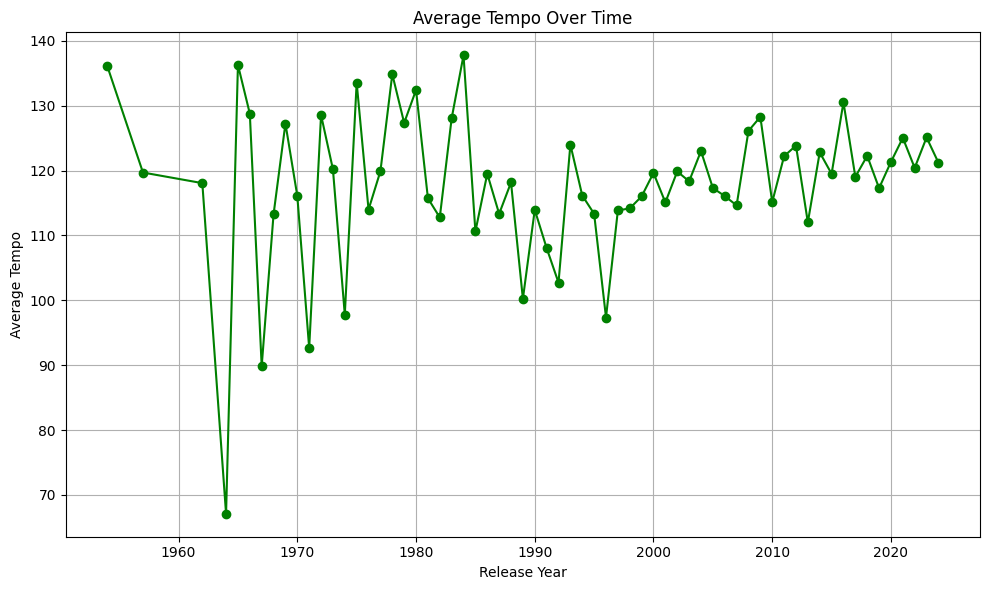

In [9]:
# Convert datetime and extract year
high_song_popularity['release_date'] = pd.to_datetime(high_song_popularity['track_album_release_date'], errors='coerce')
high_song_popularity['release_year'] = high_song_popularity['release_date'].dt.year

# Average tempo per year
avg_tempo_per_year = high_song_popularity.groupby('release_year')['tempo'].mean().reset_index()

plt.figure(figsize=(10,6))
plt.plot(avg_tempo_per_year['release_year'], avg_tempo_per_year['tempo'], marker='o', color='green')
plt.title('Average Tempo Over Time')
plt.xlabel('Release Year')
plt.ylabel('Average Tempo')
plt.grid(True)
plt.tight_layout()
plt.show()

### Genre-Based Feature Averages


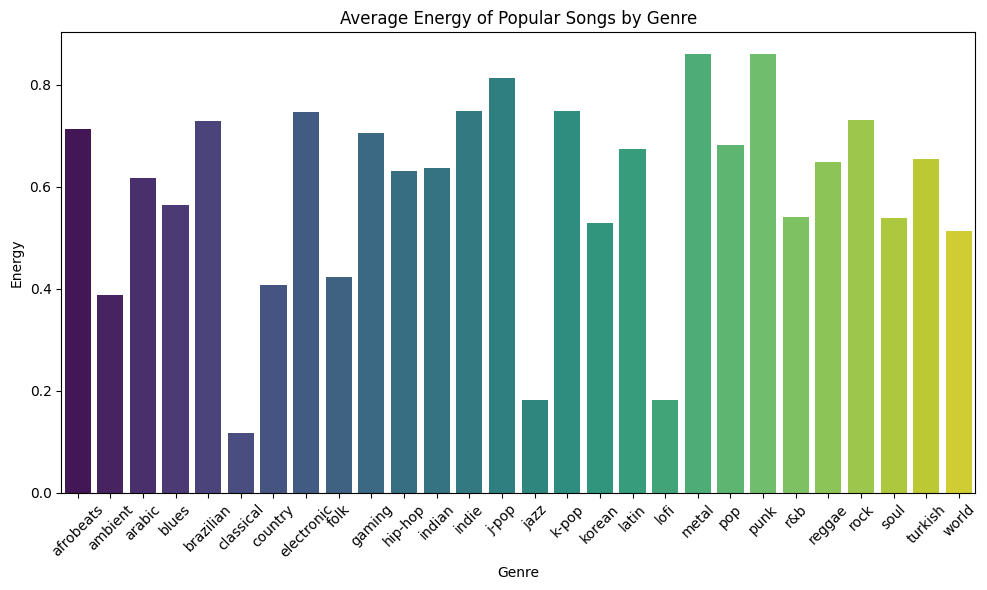

In [10]:
# Add column
high_song_popularity["popularity_label"] = "Popular"
low_song_popularity["popularity_label"] = "Non-Popular"

genre_feature_avg = high_song_popularity.groupby('playlist_genre')[['energy', 'danceability', 'loudness', 'tempo', 'valence',
    'acousticness', 'instrumentalness', 'speechiness']].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=genre_feature_avg, x='playlist_genre', y='energy', hue='playlist_genre', palette='viridis', legend=False)
plt.title('Average Energy of Popular Songs by Genre')
plt.xticks(rotation=45)
plt.ylabel('Energy')
plt.xlabel('Genre')
plt.tight_layout()


plt.show()

# Model

## Cleaning data for model

In [11]:
# Combined popularity
combined_popularity_df = pd.concat([high_song_popularity, low_song_popularity], ignore_index=True)

# Create "hit" column from "track_popularity" for 1 and 0 input. If populartiy is lower than 70 it's 0 and higher it's 1
combined_popularity_df['hit'] = combined_popularity['track_popularity'].apply(lambda x: 1 if x >= 70 else 0)

# Drop useless columns for the model
combined_popularity_df = combined_popularity_df.drop(columns=['track_name', 'track_artist', 'id', 'track_popularity', 'track_album_release_date',
                                                               'release_date', 'release_year', 'popularity_label', 'playlist_genre', 'playlist_subgenre'])


## Train Model

In [12]:
# Split feature and target
X = combined_popularity_df.drop('hit', axis=1) # Audio features only
y = combined_popularity_df['hit'] # This is the target which conatains the answer sheet with hit 0 means no hit and 1 means hit

#print(X.sum())

# Test
#y.name = 'target'
#combined_popularity_df = pd.concat([X, y], axis= 1)
#correlation = combined_popularity_df.corr()
#print(correlation['target'].sort_values(ascending=False))

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Test
#scaler = StandardScaler()
#X_train_scaled = scaler.fit_transform(X_train)
#X_test_scaled = scaler.transform(X_test)

# Check for overlapping rows
X_train_df = X_train.copy()
X_test_df = X_test.copy()

X_train_df['is_train'] = True
X_test_df['is_train'] = False

#combined_split = pd.concat([X_train_df, X_test_df])
#combined_split = combined_split.drop_duplicates(keep=False)

# Rebuild X and y without overlaps
#X_clean = combined_split.drop(columns=['is_train'])
#y_clean = y.loc[X_clean.index]

#overlap = pd.merge(X_train_df, X_test_df, how='inner')
#print(f"Overlapping rows between train and test sets: {len(overlap)}")


# Train model
#model = XGBClassifier(use_label_encoder=False, eval_metric="logloss")
#model.fit(X_train, y_train)

# Predict and evalute
#y_pred = model.predict(X_test)
#print(confusion_matrix(y_test, y_pred))
#print(classification_report(y_test, y_pred))